In [1]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import warnings
import scienceplots
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

plt.style.use(['ieee','no-latex'])
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.titlesize'] = 20
warnings.filterwarnings('ignore')
sns.set_style('dark')


# Plot values for training with noise

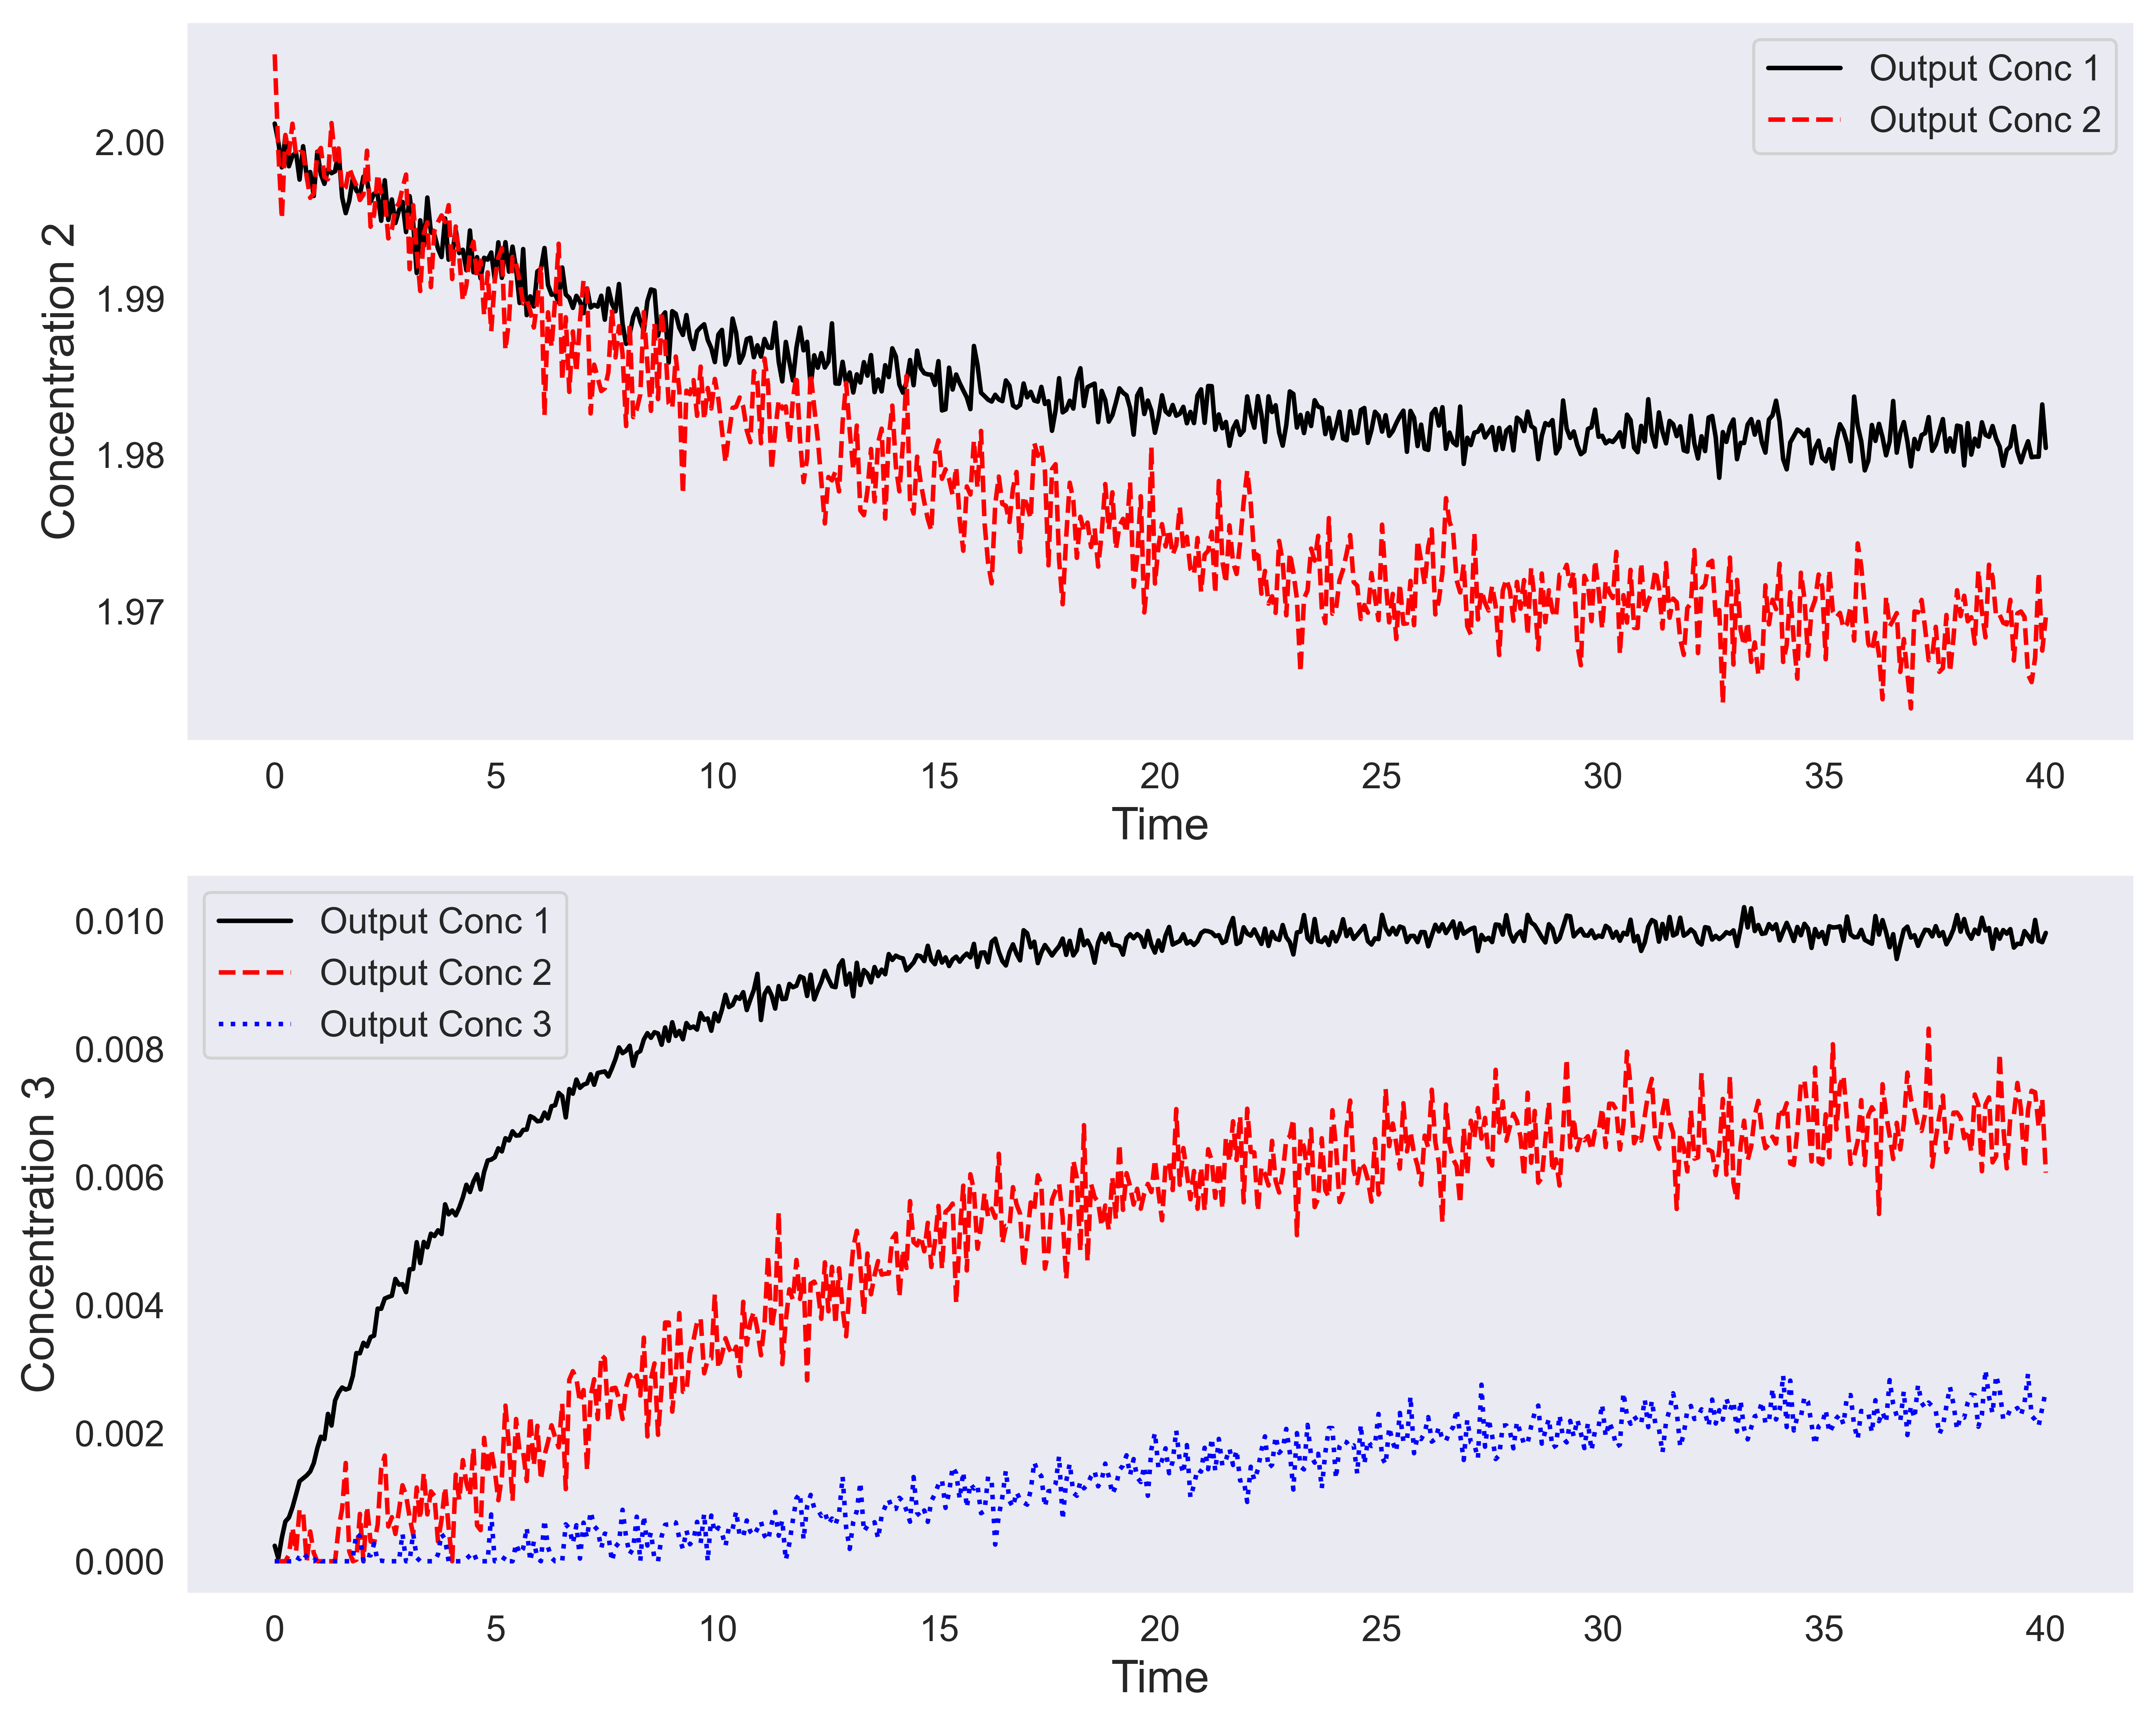

In [40]:
F, V = 2, 20
ca0, cb0 = 2, 2
cx0, cy0, cz0 = 0, 0, 0

def reactor_equations(t, state, F, V, k1, k2, k3):
    ca, cb, cx, cy, cz = state
    cx0, cy0, cz0 = 0, 0, 0

    dca_dt = F * (ca0 - ca) / V - k1 * ca * cb
    dcb_dt = (F * cb0 - F * cb) / V - k1 * ca * cb - k2 * cb * cx - k3 * cb * cy
    dcx_dt = (F * cx0 - F * cx) / V + k1 * ca * cb - k2 * cb * cx
    dcy_dt = (F * cy0 - F * cy) / V + k2 * cb * cx - k3 * cb * cy
    dcz_dt = (F * cz0 - F * cz) / V + k3 * cy * cb

    return [dca_dt, dcb_dt, dcx_dt, dcy_dt, dcz_dt]

def simulate_reaction(F, V, ca0, cb0, cx0, cy0, cz0, k1, k2, k3):
    init_conditions = [ca0, cb0, cx0, cy0, cz0]
    solution = solve_ivp(
        reactor_equations,
        [0, 4*V/F],
        init_conditions,
        args=(F, V, k1, k2, k3),
        method='BDF',
        rtol=1e-5,
        t_eval=np.linspace(0, 4*V/F, 500)
    )
    final_conditions = solution.y
    time = solution.t
    return time, final_conditions

k1,k2,k3 = 0.0005,0.05,0.02
time, final_conditions = simulate_reaction(F, V, ca0, cb0, 0, 0, 0, k1, k2, k3)

# Extract time values and concentrations
time_values = time
concentrations = final_conditions
# Generate noise
for i,conc in enumerate(concentrations):
    noise_percentage = 50
    order_of_magnitude = np.log10(np.median(np.abs(conc[1:]-conc[:-1])) + 1e-10)
    noise_level = noise_percentage * 10**order_of_magnitude
    noise = np.random.normal(0, noise_level, conc.shape)
    # Ensure concentrations don't go below zero after adding noise
    new_conc = conc + noise
    new_conc[new_conc < 0] = 0

    concentrations[i] = new_conc

# Plot each output
plt.figure(figsize=(10, 8))
plt.subplot(2,1,1)
for i, concentration in enumerate(concentrations[:2]):
    plt.plot(time_values, concentration, label=f'Output Conc {i + 1}')
    plt.xlabel('Time')
    plt.ylabel(f'Concentration {i + 1}')
    plt.legend()

plt.subplot(2,1,2)
for i, concentration in enumerate(concentrations[2:]):
    plt.plot(time_values, concentration, label=f'Output Conc {i + 1}')
    plt.xlabel('Time')
    plt.ylabel(f'Concentration {i + 1}')
    plt.legend()

plt.tight_layout()
plt.show()

# Data generation - adding noise


In [67]:
def reactor_equations(t, state, F, V, k1, k2, k3):
    ca, cb, cx, cy, cz = state

    dca_dt = F * (ca0 - ca) / V - k1 * ca * cb
    dcb_dt = (F * cb0 - F * cb) / V - k1 * ca * cb - k2 * cb * cx - k3 * cb * cy
    dcx_dt = (F * cx0 - F * cx) / V + k1 * ca * cb - k2 * cb * cx
    dcy_dt = (F * cy0 - F * cy) / V + k2 * cb * cx - k3 * cb * cy
    dcz_dt = (F * cz0 - F * cz) / V + k3 * cy * cb

    return [dca_dt, dcb_dt, dcx_dt, dcy_dt, dcz_dt]

def simulate_reaction(F, V, ca0, cb0, cx0, cy0, cz0, k1, k2, k3):
    init_conditions = [ca0, cb0, cx0, cy0, cz0]
    solution = solve_ivp(
        reactor_equations,
        [0, 3*V/F],
        init_conditions,
        args=(F, V, k1, k2, k3),
        method='BDF',
        rtol=1e-5,
        t_eval=np.linspace(0, 3*V/F, 500)
    )
    concentrations = solution.y
    time = solution.t
    return time, concentrations

# Inputs for train data
flow_rates = np.linspace(0.001, 0.1, 15)
Vs = np.linspace(0.5, 10, 15)
ca_init = np.linspace(0.1, 1, 5)
cb_init = np.linspace(0.1, 1, 5)

# # Simplify noise
# flow_rates = [0.05]
# Vs = [5]
# ca_init = [0.5]
# cb_init = [0.5]

k1,k2,k3=0.0005,0.05,0.02

df = pd.DataFrame(columns=[
    'ID', 'Flow_rate', 'Volume', 'Ca0', 'Cb0', 'Cx0', 
    'Cyo', 'Czo', 'Time', 'Caf', 'Cbf', 'Cxf', 'Cyf', 'Czf'
])

total_iterations = len(flow_rates) * len(Vs) * len(ca_init) * len(cb_init)

with tqdm(total=total_iterations) as pbar:
    for sample, (fr, v, ca, cb) in \
    enumerate(itertools.product(flow_rates, Vs, ca_init, cb_init), start=1):
        F, V, ca0, cb0 = fr, v, ca, cb
        cx0, cy0, cz0 = 0, 0, 0

        time, concentrations = simulate_reaction(F, V, ca0, cb0, cx0, cy0, cz0, k1, k2, k3)

        # Generate noise
        for i,conc in enumerate(concentrations):
            noise_percentage = 100
            order_of_magnitude = np.log10(np.median(np.abs(conc[1:]-conc[:-1])) + 1e-10)
            noise_level = noise_percentage * 10**order_of_magnitude
            noise = np.random.normal(0, noise_level, conc.shape)
            # Ensure concentrations don't go below zero after adding noise
            new_conc = conc + noise
            new_conc[new_conc < 0] = 0

            concentrations[i] = new_conc

        temp_df = pd.DataFrame({
            'ID': sample,
            'Flow_rate': F,
            'Volume': V,
            'Ca0': ca0,
            'Cb0': cb0,
            'Cx0': cx0,
            'Cyo': cy0,
            'Czo': cz0,
            'Time': time/(3*V/F),
            'Caf': concentrations[0],
            'Cbf': concentrations[1],
            'Cxf': concentrations[2],
            'Cyf': concentrations[3],
            'Czf': concentrations[4],
        })

        df = pd.concat([df, temp_df], ignore_index=True)

        pbar.update(1)  # Update progress bar

df.to_csv('train_data_noise.csv',index=False)

100%|██████████| 15/15 [00:00<00:00, 194.27it/s]


# Modelling 

In [10]:
df = pd.read_csv('train_data_noise.csv')
# 80% of IDs (total 5625) for train and remaining for test (4500)
lower_lim = 4000
X_train = df[df['ID'] <= lower_lim]\
    [['Flow_rate', 'Volume', 'Ca0', 'Cb0', 'Cx0', 'Cyo', 'Czo','Time']]
y_train = df[df['ID'] <= lower_lim][['Caf', 'Cbf', 'Cxf', 'Cyf', 'Czf']]
X_test = df[(lower_lim < df['ID'])]\
    [['Flow_rate', 'Volume', 'Ca0', 'Cb0', 'Cx0', 'Cyo', 'Czo','Time']]
y_test = df[(lower_lim < df['ID'])][['Caf', 'Cbf', 'Cxf', 'Cyf', 'Czf']]

# Standardize features
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

In [11]:
# Define a simple PyTorch model
class ANNModel(nn.Module):
    def __init__(self, input_size, hidden_layers, hidden_nodes, output_size):
        super(ANNModel, self).__init__()

        # Input layer
        self.layers = [nn.Linear(input_size, hidden_nodes), nn.Tanh()]

        # Hidden layers
        for _ in range(hidden_layers - 1):
            self.layers.extend([nn.Linear(hidden_nodes, hidden_nodes), nn.Tanh()])

        # Output layer
        self.layers.append(nn.Linear(hidden_nodes, output_size))

        # Create the sequential model
        self.model = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.model(x)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32).to(device)

# Parameters
input_size = X_train_tensor.shape[1]
hidden_layers = 4
hidden_nodes = 128
output_size = 5
batch_size = 500
num_epochs = 50

# Initialize the PyTorch model, loss function, and optimizer
model = ANNModel(input_size, hidden_layers, hidden_nodes, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Lists to store training history
mse_history_train = []
r2_history_train = []
mse_history_val = []
r2_history_val = []

# Training loop
progress_bar = tqdm(range(num_epochs), desc="Training")

for epoch in progress_bar:
    # Training
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # Move data to GPU
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        # Predict on training set
        y_train_pred = model(X_train_tensor).cpu().numpy()
        y_train_pred = scaler_y.inverse_transform(y_train_pred)

        # Predict on validation set
        y_val_pred = model(X_test_tensor).cpu().numpy()
        y_val_pred = scaler_y.inverse_transform(y_val_pred)

        # Calculate metrics
        mse_train = mean_squared_error(y_train, y_train_pred)
        r2_train = r2_score(y_train, y_train_pred)
        mse_val = mean_squared_error(y_test, y_val_pred)
        r2_val = r2_score(y_test, y_val_pred)

        # Append metrics to history
        mse_history_train.append(mse_train)
        r2_history_train.append(r2_train)
        mse_history_val.append(mse_val)
        r2_history_val.append(r2_val)

    progress_bar.set_postfix({'MSE (Train)': mse_train, 'MSE (Val)': mse_val, 
                              'R2 (Train)': r2_train, 'R2 (Val)': r2_val})

Training: 100%|██████████| 50/50 [1:20:52<00:00, 97.05s/it, MSE (Train)=0.000152, MSE (Val)=0.000824, R2 (Train)=0.99, R2 (Val)=0.944]    


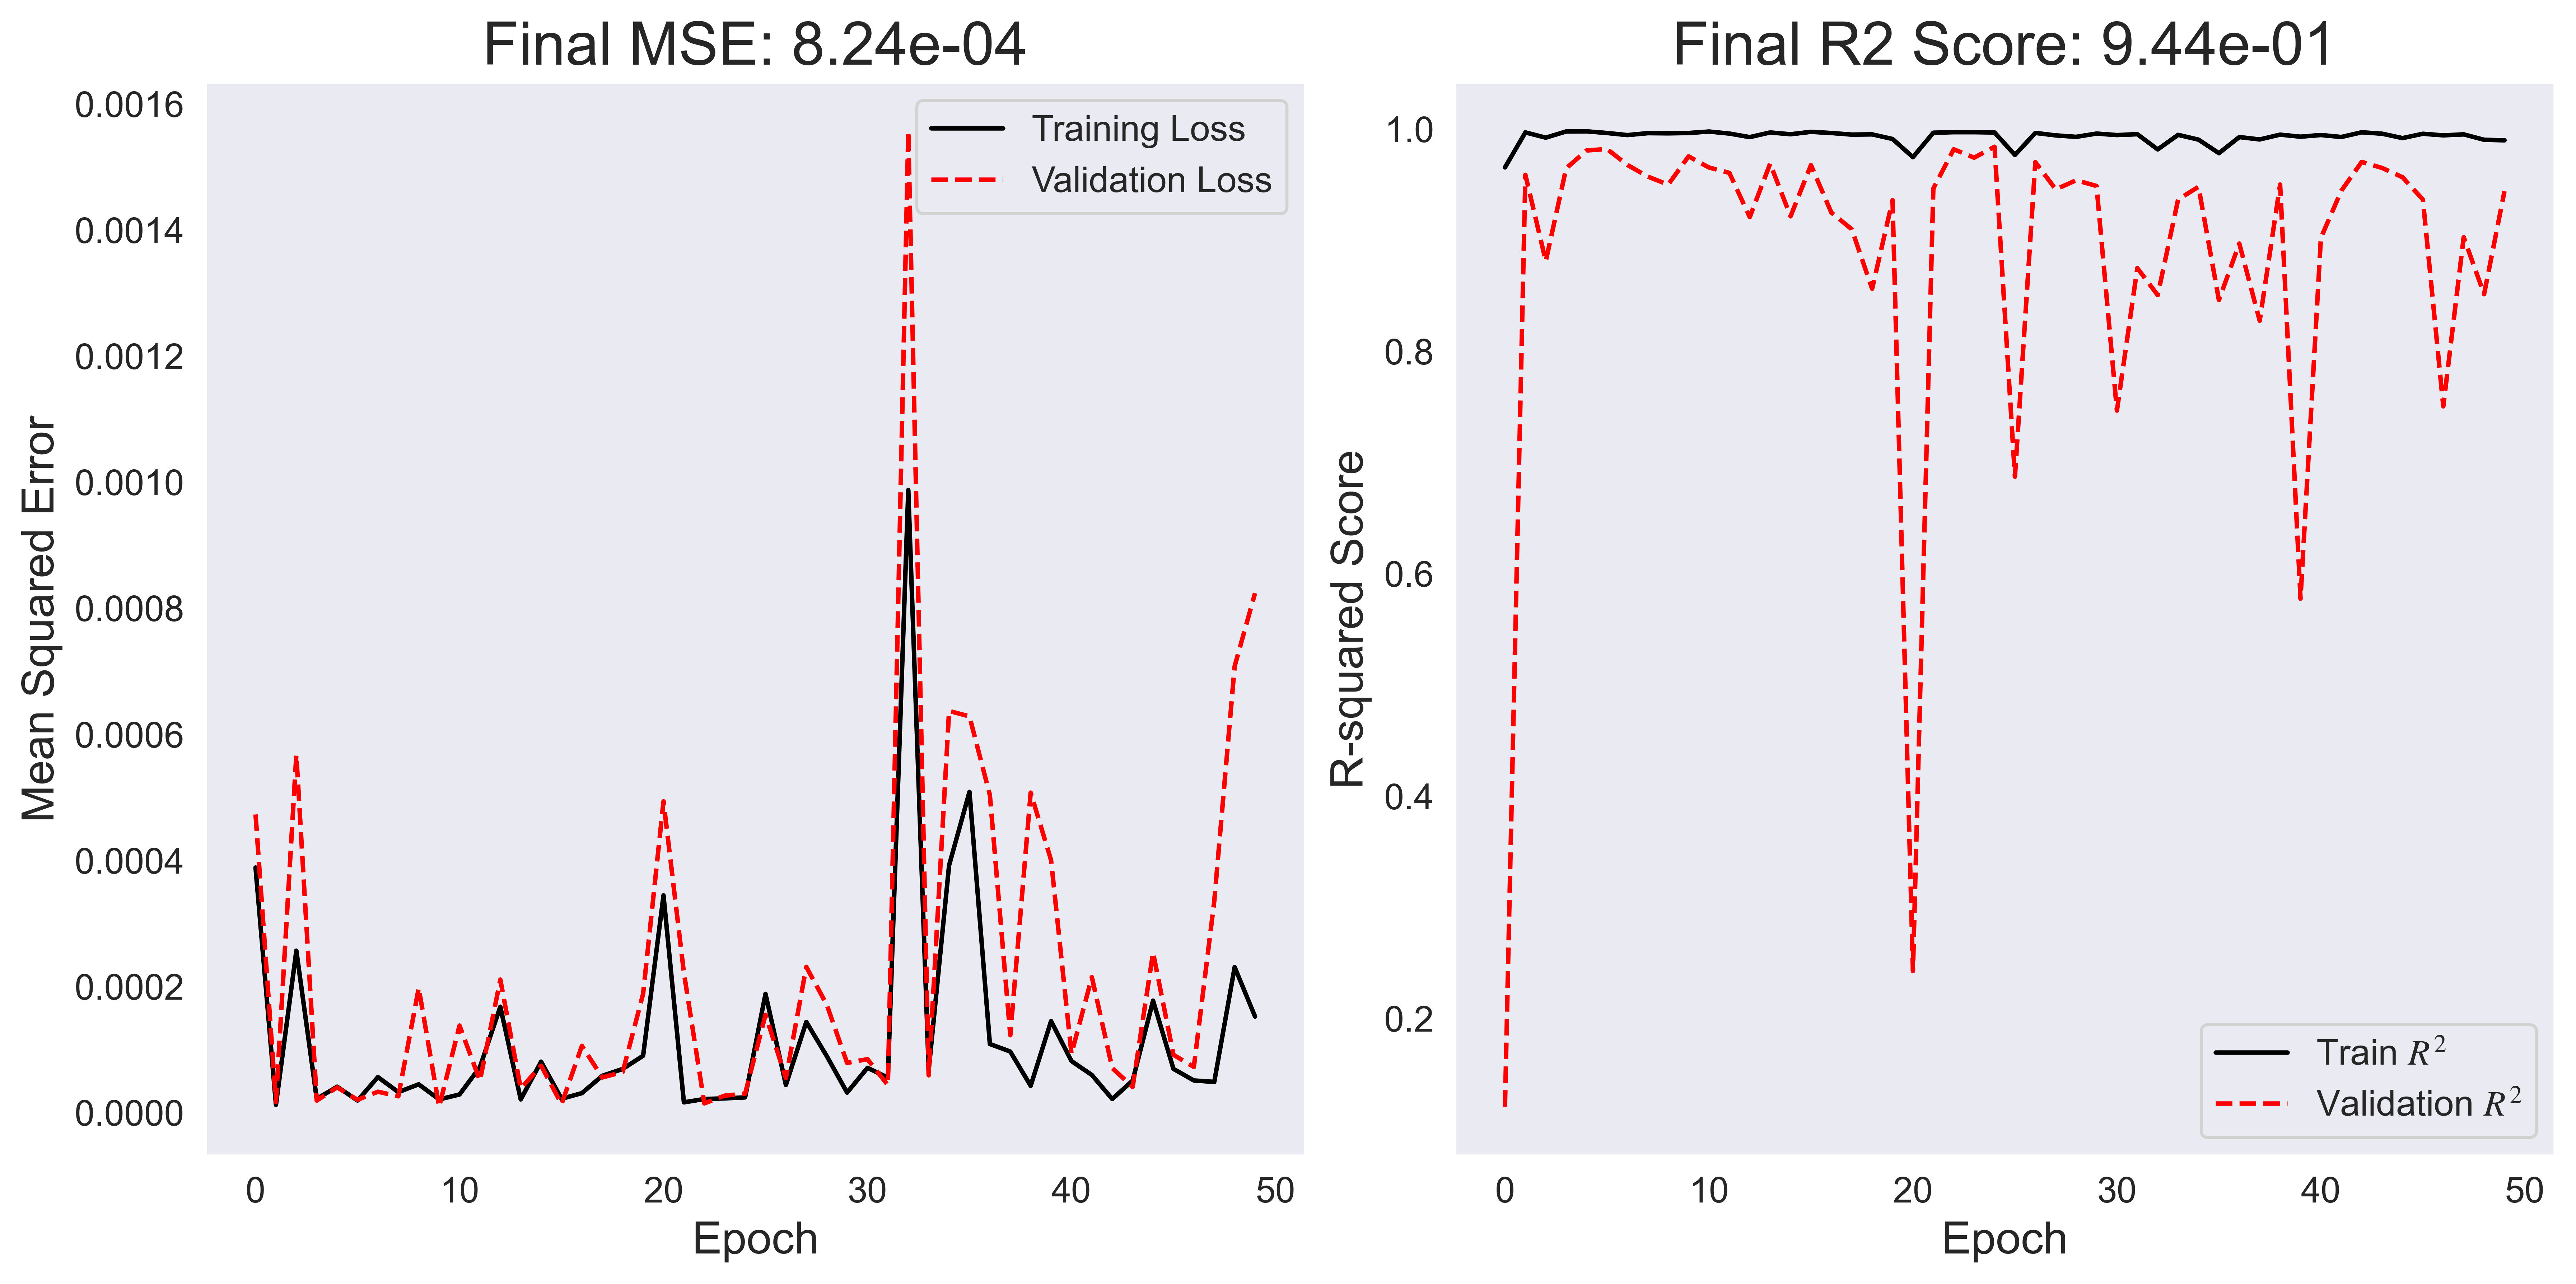

In [12]:
# Plot training and validation loss over epochs
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(mse_history_train, label='Training Loss')
plt.plot(mse_history_val, label='Validation Loss')
plt.title(f'Final MSE: {mse_history_val[-1]:.2e}')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()

# Plot training and validation R2 score over epochs
plt.subplot(1, 2, 2)
plt.plot(r2_history_train, label='Train $R^2$')
plt.plot(r2_history_val, label='Validation $R^2$')
plt.title(f'Final R2 Score: {r2_history_val[-1]:.2e}')
plt.xlabel('Epoch')
plt.ylabel('R-squared Score')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
# Load the test data
# df_test = pd.read_csv('test_data.csv')
df_test = df
df_test = df_test[df_test['ID'] < 6]

# Extract features for the new test set
features_test = df_test[['Flow_rate', 'Volume', 'Ca0', 'Cb0', 'Cx0', 'Cyo', 'Czo', 'Time']]

# Standardize features
features_test_scaled = scaler_X.transform(features_test)

# Convert to PyTorch tensor
X_tensor = torch.tensor(features_test_scaled, dtype=torch.float32).to(device)

# Ensure the model is in evaluation mode
model.eval()

# Predict concentrations using the trained model
with torch.no_grad():
    y_pred_test_scaled = model(X_tensor).cpu().numpy()
    y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled)

# Plot actual concentration values and predicted concentration values against time
time_values = range(df_test.shape[0])

plt.figure(figsize=(12, 20))
for i, col in enumerate(df_test.columns[-5:]):
    plt.subplot(5, 1, i + 1)
    plt.plot(time_values, df_test[col], '.', label='Actual', alpha=0.5)
    plt.plot(time_values, y_pred_test[:, i], '.', label='Predicted', alpha=0.5)
    plt.title(f'Actual vs Predicted {col}')
    plt.xlabel('Time')
    plt.ylabel('Concentration')
    plt.legend()

plt.tight_layout()
plt.show()
